In [6]:
import numpy as np
import matplotlib.pyplot as plt


color function test

# create array of numpy


In [148]:
def arr_phis(dw_density,dw_pinning,dw_shift):
    """get array of phi and delta-phi about soliton lattice    
    Args: 
        dw_density (float,[0,1)): density of domain wall. if 1, 1 domain per length 1
        dw_pinning (float,+): pinning of domain wall. if 1, sigma is 1
        dw_shift (float,[0,3)): shift of domain wall. if 0, reference dw's position is 0
    Returns:
        x (arr,(900,)): position of domain wall.
        phi (arr,(900,)): phase of domain wall.
        delta_phi (arr,(900,)): phase difference of domain wall.
    """
    x = np.linspace(-1, 2, 1800)
    z_min = int(np.ceil((-1 - dw_shift) / dw_density))
    z_max = int(np.floor((2 - dw_shift) / dw_density))
    dw_pos = dw_density * np.arange(z_min, z_max + 1) + dw_shift
    print(dw_pos)
    from scipy.stats import norm
    delta_phi = np.zeros_like(x)
    for pos in dw_pos:
        delta_phi += norm.pdf(x, loc=pos, scale=dw_pinning)    
    phi = np.cumsum(delta_phi) * (x[1] - x[0])# * (2 * np.pi / 3)
    phi -= phi[np.argmin(np.abs(x))]
    return x, phi, delta_phi,dw_pos

    


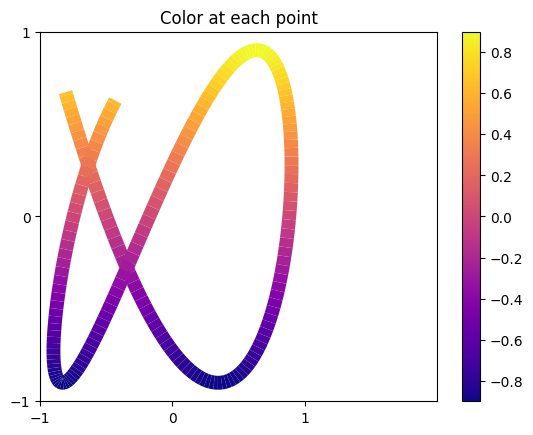

In [26]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import LineCollection


def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)


# -------------- Create and show plot --------------
# Some arbitrary function that gives x, y, and color values
t = np.linspace(-7.4, -0.5, 200)
x = 0.9 * np.sin(t)
y = 0.9 * np.cos(1.6 * t)
color = np.linspace(0, 2, t.size)

# Create a figure and plot the line on it
fig1, ax1 = plt.subplots()
lines = colored_line(x, y, y, ax1, linewidth=10, cmap="plasma")
fig1.colorbar(lines)  # add a color legend

# Set the axis limits and tick positions
ax1.set_xlim(-1, 2)
ax1.set_ylim(-1, 1)
ax1.set_xticks((-1, 0, 1))
ax1.set_yticks((-1, 0, 1))
ax1.set_title("Color at each point")

plt.show()

In [11]:
x,phi,delta_phi,dw_pos = arr_phis(
    dw_density=.3,
    dw_pinning=.01,
    dw_shift=.1)

[-0.8 -0.5 -0.2  0.1  0.4  0.7  1.   1.3  1.6  1.9]


In [123]:
case_78K = arr_phis(
    dw_density=.4,
    dw_pinning=.01,
    dw_shift=.1)
case_110K = arr_phis(
    dw_density=.15,
    dw_pinning=.05,
    dw_shift=.1)    

import pandas as pd
data=[case_78K,case_110K]
df = pd.DataFrame(data,columns=["x", "phi", "delta_phi","dw_pos"])
df.iloc[1]['delta_phi'][0] = 0
df.iloc[1]['delta_phi'][-1] = np.max(df.iloc[0]['delta_phi']) 

[-0.7 -0.3  0.1  0.5  0.9  1.3  1.7]
[-0.95 -0.8  -0.65 -0.5  -0.35 -0.2  -0.05  0.1   0.25  0.4   0.55  0.7
  0.85  1.    1.15  1.3   1.45  1.6   1.75  1.9 ]


In [124]:
draw = dict()
nmT = ['78K', '110K']
nmInfo = ['dphi', 'phi']

for idt in range(len(df)):
    dt = df.iloc[idt]
    x = dt["x"]
    delta_phi = dt["delta_phi"]
    phi = dt["phi"]

    # [수정 포인트] 
    # 람다 정의 시점의 데이터를 캡처하기 위해 기본 인자(x=x, dp=delta_phi, p=phi)를 사용
    lines_dphi = lambda ax, x=x, dp=delta_phi: colored_line(x, dp, dp, ax, linewidth=2, cmap='plasma')
    
    # 여기서도 x=x, p=phi로 현재 루프의 값을 고정
    lines_phi = lambda ax, x=x, p=phi: colored_line(x, p, np.mod(p, 3), ax, linewidth=4, cmap="hsv")

    draw[nmT[idt] + nmInfo[0]] = lines_dphi
    draw[nmT[idt] + nmInfo[1]] = lines_phi

(0.0, 7.0)

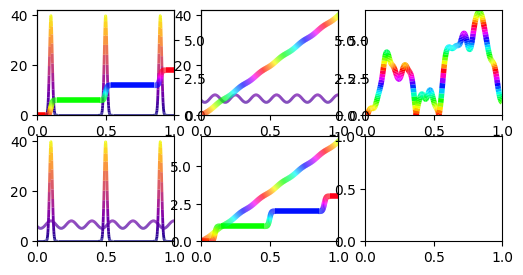

In [159]:
fig,axs = plt.subplots(2,3,figsize=(6,3))

draw['78Kdphi'](axs[1][0])
draw['78Kphi'](axs[1][1])
draw['110Kdphi'](axs[1][0])
draw['110Kphi'](axs[1][1])

axs[1][0].set_xlim(0,1)
axs[1][0].set_ylim(0,42)
axs[1][1].set_xlim(0,1)
axs[1][1].set_ylim(0,7)

draw['78Kdphi'](axs[0][0])
axs[0][0].set_xlim(0,1)
axs[0][0].set_ylim(0,42)
ax00 = axs[0][0].twinx()
draw['78Kphi'](ax00)
ax00.set_ylim(0,7)

draw['110Kdphi'](axs[0][1])
axs[0][1].set_xlim(0,1)
axs[0][1].set_ylim(0,42)
ax00 = axs[0][1].twinx()
draw['110Kphi'](ax00)
ax00.set_ylim(0,7)

x = np.linspace(0, 1, 300)
from scipy.ndimage import gaussian_filter1d
np.random.seed(43)
y = gaussian_filter1d(np.cumsum(np.random.randn(300)), sigma=5)
y = np.abs(y)*.55
lines_phi = lambda ax, x=x, p=y: colored_line(x, p, np.mod(p, 3), ax, linewidth=4, cmap="hsv")
lines_phi(axs[0][2])
axs[0][2].set_xlim(0,1)
axs[0][2].set_ylim(0,7)
# axs[0][2].plot(x, y)




Text(0.5, 1.0, 'test')

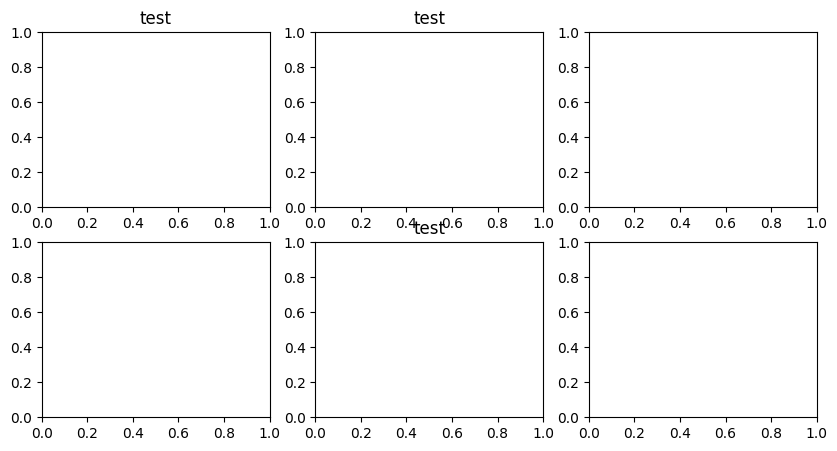

In [ ]:
fig,axs = plt.subplots(2,3,figsize=(10,5))
axs[0,0].set_title('test')
axs[0,1].set_title('test')
axs[1,1].set_title('test')